<a href="https://colab.research.google.com/github/oleksandrasoldatkina/test_idoven/blob/main/ECGanalysis_PTBxl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRO**
Here I walk you through my solution to the task.
Usually when I work with the data, I first try to load and visualize it and, second, read if and how it needs to be preprocessed.
Next, I go into researching the literature to learn what I should be able to infer from the data, and wondering what I could figure out myself.

Here I tried to reproduce my workflow, but I had to stop in the research phase, just because I have a lot of other things to do.

In the end of the file I give a brief summary and reflection on the task.



# Load the data
Choose how to load - from the physionet website (0) or use it from your own location (1)

In [ ]:
data_load_option = 1
if data_load_option==0:
  !wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.2/
  path = '/content/physionet.org/files/ptb-xl/1.0.2/'
else:
  path = '/yourpath/physionet.org/files/ptb-xl/1.0.2/'

Install and load the necessary libraries, which here will be the standard ones + wfdb for treating ecg data.



In [ ]:
!pip install wfdb


In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
from scipy import signal


First, I load the metadata, and integrate the diagnosis in, so that later I can look at controls and disease if I want to.

In [ ]:
#Load metadata, aggregate to have a diagnostic superclass (code from the physionet[1])
metadata = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
metadata.scp_codes = metadata.scp_codes.apply(lambda x: ast.literal_eval(x))

agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
metadata['diagnostic_superclass'] = metadata.scp_codes.apply(aggregate_diagnostic)
metadata['diagnostic_superclass'] = metadata['diagnostic_superclass'].astype(str)



# Quick visualization of one raw ECG
I plot one normal ECG to see if metadata R
peaks align and whether it's already informative.

ECG of record #1692


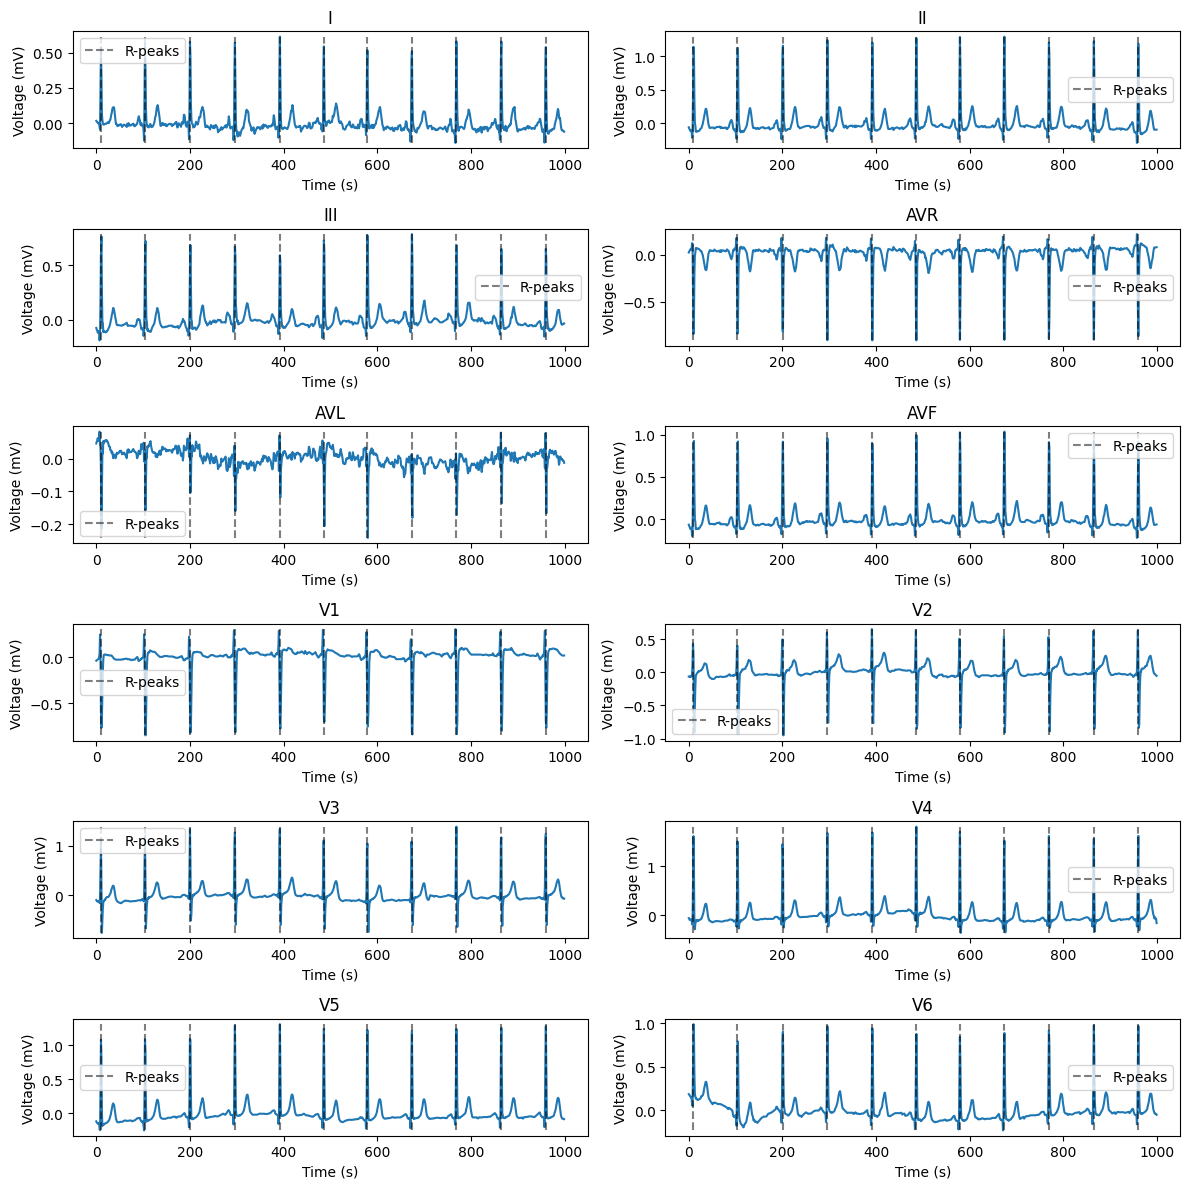

In [ ]:
# General setting
num_leads = 12
lead_labels = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
sampling_rate = 100
np.random.seed(24)

# Pick a "norm" record and load it in
norm_indices = metadata[metadata['diagnostic_superclass'].str.contains('NORM')].index
record_idx = np.random.choice(norm_indices)
record_idx_formatted = '{:05}'.format(record_idx)
record_name = 'records100/' + record_idx_formatted[0:2] + '000/' + record_idx_formatted + '_lr'
record = wfdb.rdrecord(path + record_name)

# Read the signal and sampling frequency
donor_ecg = record.p_signal

# Read R-peak annotation from metadata
r_peaks_s = metadata.loc[record_idx, 'r_peaks'].strip("[]")
r_peaks = [int(val) for val in r_peaks_s.split()]
print("ECG of record #" + str(record_idx))
plt.figure(figsize=(12, 12))
for lead_idx in range(num_leads):
    plt.subplot(6, 2, lead_idx + 1)
    plt.plot(donor_ecg[:, lead_idx])
    plt.vlines(r_peaks, ymin=np.min(donor_ecg[:, lead_idx]), ymax=np.max(donor_ecg[:, lead_idx]), label='R-peaks', linestyle='dashed', color='black', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title(lead_labels[lead_idx])
    plt.legend()
plt.tight_layout()
plt.show()




The peaks do align, but we see noise. Doctors shouldn't see noise, they deserve better. Let's filter the data and remove the wandering baseline, and then we will see better the signal.

# Data preprocessing (for one sample)
Here I perform the simplest filtering and visualize the data after baseline correction

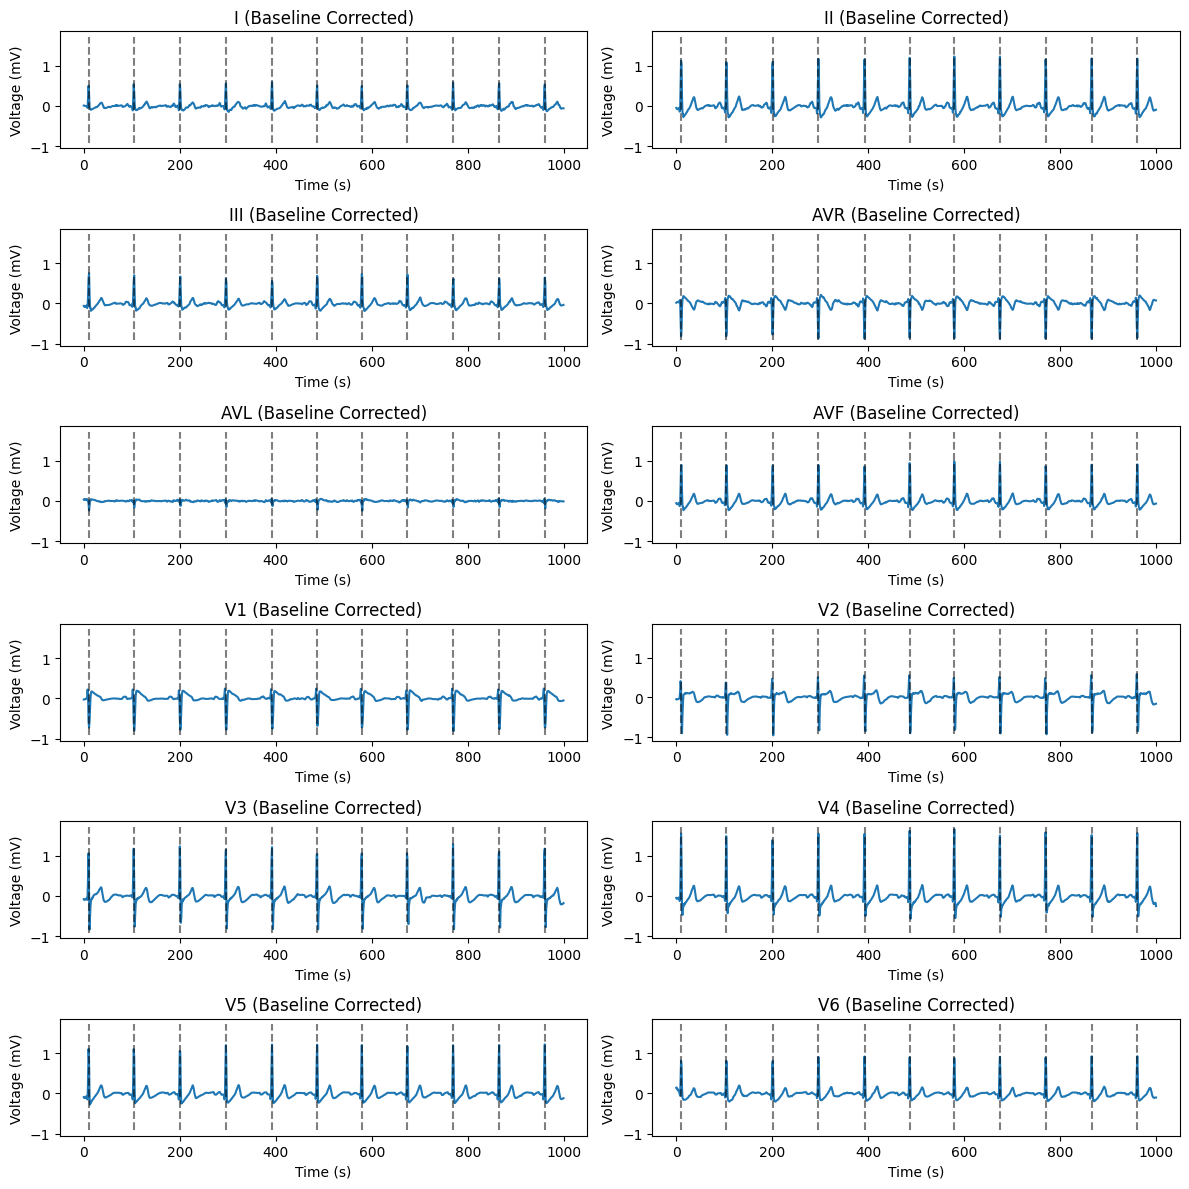

In [ ]:
# Parameters
nyquist_freq = 0.5 * sampling_rate
baseline_window = 0.5

# Apply a bandpass filter to remove noise and baseline wander
lowcut = 0.5  # Lower cutoff frequency in Hz
highcut = 49.0  # Upper cutoff frequency in Hz
b, a = signal.butter(4, [lowcut / nyquist_freq, highcut / nyquist_freq], btype="band")
filtered_ecg = signal.lfilter(b, a, donor_ecg, axis=0)

# Calculate the number of samples in the baseline window
baseline_window_size = int(sampling_rate * baseline_window)

# Initialize figure for plotting
plt.figure(figsize=(12, 12))

# Iterate through each lead and plot baseline-corrected signal
for lead_idx, lead_data in enumerate(filtered_ecg.T):
    # Calculate baseline using a moving average
    baseline = np.convolve(lead_data, np.ones(baseline_window_size) / baseline_window_size, mode='same')

    # Subtract baseline from the signal
    baseline_corrected_lead = lead_data - baseline

    # Plot the baseline-corrected ECG signal for each lead
    plt.subplot(6, 2, lead_idx + 1)
    plt.plot(baseline_corrected_lead)
    plt.vlines(r_peaks, ymin=np.min(filtered_ecg), ymax=np.max(filtered_ecg), label='R-peaks', linestyle='dashed', color='black', alpha = 0.5)

    plt.title("Lead"+lead_labels[lead_idx]+ (Baseline Corrected)")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")

# Adjust layout and display plot
plt.tight_layout()
plt.show()



Better. Now I want to analyze, but let's first do the direct tasks.
# Heart Rate: Average and total

To calculate the heartbeat rate we use the R-peaks from the annotation that we identified earlier. (We could potentially infer them using available algorithms, but here we find R-peaks annotated, so let's leave it for another time).

Average heartbeat is calculated as the number of R-peaks, beats, normalized to sampling rate, per minute.

Total heartrate is calculated as the total number of R-peaks in the recording 10-second window (in bpm).



In [ ]:
# Calculate RR intervals
rr_intervals = np.diff(r_peaks) / sampling_rate

# Calculate average and total heart rate
average_heart_rate = 60 / np.mean(rr_intervals)  # in bpm
total_heart_rate = len(rr_intervals) / (len(filtered_ecg) / sampling_rate) * 60  # in bpm

print("Average Heart Rate:", average_heart_rate, "bpm")
print("Total Heart Rate:", total_heart_rate, "bpm")



Average Heart Rate: 63.15789473684211 bpm
Total Heart Rate: 60.0 bpm


# Identification of QRS complexes
Again, here I use the annotated R-peaks, and as usually the Q and S waves are inferred as those just preceding and just following the R-peaks, I just illustrate Q and S with constant offsets.

If I were to identify each automatically, I would identify them all with an available algorithm or develop a specific one if chasing some clue on diagnosis.

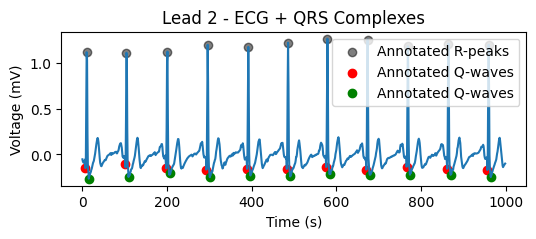

In [ ]:
# To find wave coordinates corresponding to R-peaks
annotated_rpeaks_indices = np.array(r_peaks)
annotated_rpeaks_indices = annotated_rpeaks_indices.astype(int)
plt.figure(figsize=(6, 2))

# let's just show 1 lead for space saving
lead_idx = 1

#Plot the filtered ecg
plt.plot(filtered_ecg[:, lead_idx])
#Annotate the metadata-given R-peaks
plt.scatter(r_peaks,  filtered_ecg[annotated_rpeaks_indices, lead_idx],color='black', label='Annotated R-peaks', alpha = 0.5)
# Annotate Q-waves and S-waves using offsets from R-peaks (using contant offset here)
q_offsets = np.array([-0.03])
s_offsets = np.array([0.05])
q_peaks_indices = annotated_rpeaks_indices + (q_offsets * sampling_rate).astype(int)
s_peaks_indices = annotated_rpeaks_indices + (s_offsets * sampling_rate).astype(int)

q_peaks_indices = np.clip(q_peaks_indices, 0, len(filtered_ecg) - 1)
s_peaks_indices = np.clip(s_peaks_indices, 0, len(filtered_ecg) - 1)

plt.scatter(q_peaks_indices, filtered_ecg[q_peaks_indices, lead_idx], color='r', label='Annotated Q-waves')
plt.scatter(s_peaks_indices, filtered_ecg[s_peaks_indices, lead_idx], color='g', label='Annotated Q-waves')

plt.title(lead_labels[lead_idx]+"- ECG + QRS Complexes")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")

plt.legend(loc='upper right')
plt.show()




#Let's visualize some abnormalities
Now I want to visualize an ECG that has a different diagnosis that we can see (that usually doctors see by eye on an ECG).


ECG of record #14643


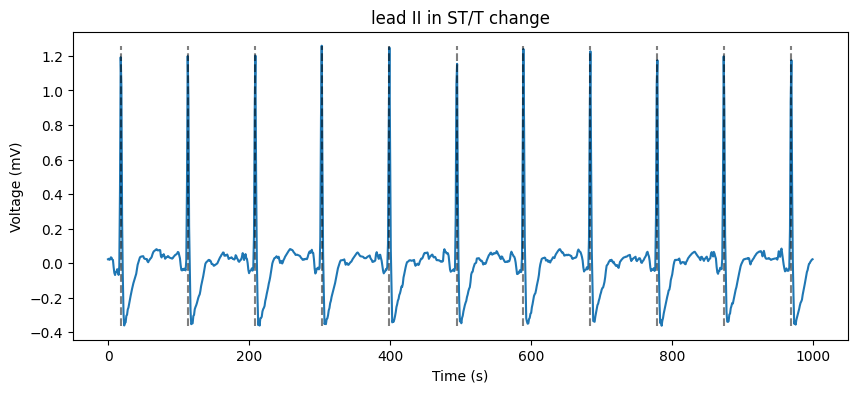

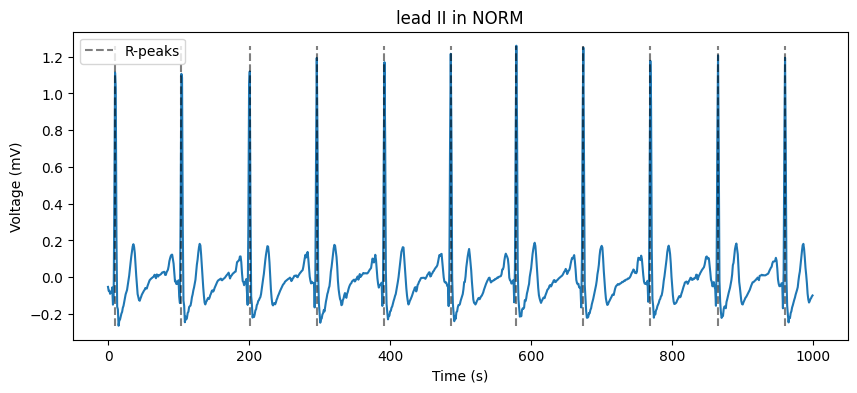

In [ ]:
# Memorize our control patient as control
norm_ecg = filtered_ecg
norm_r_peaks = r_peaks

# Pick an ECG with ST/T change and load it in
norm_indices = metadata[metadata['diagnostic_superclass'].str.contains('STTC')].index
record_idx = np.random.choice(norm_indices)
record_idx_formatted = '{:05}'.format(record_idx)
record_name = 'records100/' + record_idx_formatted[0:2] + '000/' + record_idx_formatted + '_lr'
record = wfdb.rdrecord(path + record_name)

#Read the signal and sampling frequency
sttc_ecg = record.p_signal

#Filter with the filter defined earlier
sttc_filtered_ecg = signal.lfilter(b, a, sttc_ecg, axis=0)

# Read R-peak annotation from metadata for the sttc sample
sttc_r_peaks_s = metadata.loc[record_idx, 'r_peaks'].strip("[]")
sttc_r_peaks = [int(val) for val in sttc_r_peaks_s.split()]
print("ECG of record #" + str(record_idx))
plt.figure(figsize=(10, 4))
lead_idx = 1
plt.plot(sttc_filtered_ecg[:, lead_idx])
plt.vlines(sttc_r_peaks, ymin=np.min(sttc_filtered_ecg[:, lead_idx]), ymax=np.max(sttc_filtered_ecg[:, lead_idx]), label='R-peaks', linestyle='dashed', color='black', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('lead '+lead_labels[lead_idx]+' in ST/T change')

# NORM ecg for comparison
plt.figure(figsize=(10, 4))
plt.plot(norm_ecg[:, lead_idx])
plt.vlines(norm_r_peaks, ymin=np.min(norm_ecg[:, lead_idx]), ymax=np.max(norm_ecg[:, lead_idx]), label='R-peaks', linestyle='dashed', color='black', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('lead '+lead_labels[lead_idx]+' in NORM')
plt.legend()
plt.show()



Here we can see the typical abnormality of ST/T change [2]: flattening of the T peak. I first learned about it and then discovered that it can only show in some of the leads, so it's not even a great example I aimed for.

But to me, visualizing it gives an idea on how to check for such markers systematically in the data.

My initial idea was to show such a phenomena and then quickly quantify it, but unfortunately I don't have time to implement it properly, which I would the following way:

1. Identify the subclass of STTC superclass that shows flattening (e.g., ISCI shows an T abnormality only in inferior leads);
2. Quantify flattening by identifying formally QRS and T points (and other points as well, for further analysis)
3. Check the difference with controls and other STTC subclasses.
4. Train a model to check if flattening is a good predictor.
5. Include other measures - both from the literature (QRS duration, ST duration, infraction markers) and just plain statistics on the ecg to see if my 'flattening' parameter works in combination or in interaction with other terms.
6. Find a good fit.

**6 -> 1** Another (or complementary) way would be to build a classifier and aim for best classification accuracy between all or certain diagnoses, and then check for these markers in the clusters.

Ideally, for each subclass I want to have an informed guess of how doctors diagnose this case (for instance, from here [3]), we may not see it in the ecg data even, but it is important to then understand the results of any classification. And then, ***the conclusion of our automisation effort can be either confirmed by existing medical evidence, or it can help discard outdated practices of diagnosis.***


# Summary and reflexion
Here I provide some overview of the data as I would do on the first check. If working on this data continuously, I would study the data a bit more thoroughly, given that even the rich metadata provided at Physionet could give more insights on noise sourse and that could help remove additional noise.

Then, most certainly, I would also focus more on the disease annotation and go on exploring in the literature and in the data the possible markers of conditions, as it's most exciting.

I suspect that developing an algorithm or using an existing good algorithm to identify QRS complexes could be a valuable check too, for it may be important in diagnosis. Certainly, using most of the data in full resolution (sampling_rate = 500) would be more informative.

Furthermore, training an algorithm to differentiate diagnosis based on ECG could be very interesting. I found a large variety of algorithms already developed for this database (reviews [4](https://europepmc.org/article/pmc/pmc9818170), [5](https://doi.org/10.3390/s22176503)), but in my opinion the best suited method should include educated guesses on known biomarkers along the 'fittest' classifier.

This is why here I tried to illustrate what we should be seeing on ECG for different conditions: machine learning for biological questions in my world is not an answer-giving black box, but rather computationally-assisted sound reasoning. As computationally-limited humans, we cannot possibly find all the patterns, but (at least some of :) ) the things we find algorithmically should make some biological sense.


To summarize my experience, this exercise was fun for me as an opportunity to learn basics on ECG, cardiological conditions and state of the art in automated diagnosis. If I spent more time on this, I would incorporate the findings from the literature into building a classifier sensitive to the change we expect under certain conditions that would allow us to find more than we can see.


# Bibliography
1. https://physionet.org/content/ptb-xl/1.0.2/example_physionet.py
2. Hammill S. C. Electrocardiographic diagnoses: Criteria and definitions of abnormalities, Chapter 18, MAYO Clinic, Concise Textbook of Cardiology, 3rd edition, 2007 ISBN 0-8493-9057-5
3. https://ecg.utah.edu/
4. Hammad, M., Chelloug, S. A., Alkanhel, R., Prakash, A. J., Muthanna, A., Elgendy, I. A., & Pławiak, P. (2022). Automated Detection of Myocardial Infarction and Heart Conduction Disorders Based on Feature Selection and a Deep Learning Model. Sensors (Basel, Switzerland), 22(17). https://doi.org/10.3390/s22176503
5.  Ayano YM, Schwenker F, Dufera BD, Debelee TG. Interpretable Machine Learning Techniques in ECG-Based Heart Disease Classification: A Systematic Review. Diagnostics (Basel, Switzerland). 2022 Dec;13(1):111. DOI: 10.3390/diagnostics13010111. PMID: 36611403; PMCID: PMC9818170.
